In [2]:
##########################################################################################
# Abraham Tishelman-Charny                                                               #
# 3 March 2021                                                                           #
#                                                                                        #
# The purpose of this notebook is to validate Resonant HH UL gridpacks. This can         #
# also be used to study any MadGraph 5 gridpacks.                                        #
##########################################################################################

# Thanks to:
# https://pydoc.net/pylhe/0.0.2/pylhe/ ##-- pylhe 
# https://github.com/scikit-hep/pylhe/blob/master/examples/zpeak.ipynb

In [3]:
##-- Imports 
import pylhe 
import ROOT
import math
from matplotlib import pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import pickle
from ROOT import TLorentzVector

Welcome to JupyROOT 6.22/06


In [4]:
##-- Get LHE Files assuming directory tree structure: LHE_Files/<gridpack_Type>/<files>
gridpack_Type = "GF_NMSSM"
#gridpack_Type = "GF_Spin-0"
# gridpack_Type = "GF_Spin-2"
# gridpack_Type = "VBF_Spin-0"
# gridpack_Type = "VBF_Spin-2"

files = ["LHE_Files/%s/%s"%(gridpack_Type,file) for file in os.listdir('./LHE_Files/%s'%(gridpack_Type)) if file.endswith('.lhe')] 
for file in files:
    print("Found File:",file)
print("N files:",len(files))

Found File: LHE_Files/GF_NMSSM/NMSSM_XYH_bbZZ_MX_1000_MY_850_slc7_amd64_gcc700_CMSSW_10_6_19_tarball.lhe
Found File: LHE_Files/GF_NMSSM/NMSSM_XYH_bbZZ_MX_1000_MY_85_slc7_amd64_gcc700_CMSSW_10_6_19_tarball.lhe
Found File: LHE_Files/GF_NMSSM/NMSSM_XYH_bbZZ_MX_300_MY_170_slc7_amd64_gcc700_CMSSW_10_6_19_tarball.lhe
N files: 3


In [5]:
##-- Create Pandas dataframe for each file 

##-- Parameters 
##################
debug = 0      
maxEvents = -1
lessPoints = 0
##################

##-- Element in lhe file name which has mass information 
massGPtypeDict = {
    "GF_Spin-0" : 3,
    "GF_Spin-2" : 5,
    "VBF_Spin-0" : 1,
    "VBF_Spin-2" : 1,
    "GF_NMSSM" : 4    
}
massElement = massGPtypeDict[gridpack_Type]

##-- Functions for Event Loop
def GetPt(p):
    px = p.px
    py = p.py 
    pt = np.sqrt(px**2 + py**2)
    return pt

def GetDR(eta1, eta2, phi1, phi2):
    DR = np.sqrt((eta1 - eta2)**2 + (phi1 - phi2)**2)
    return DR

##-- For each LHE file (one per gridpack)
for i_file, file in enumerate(files):

    ##-- File Printout
    print("On file:",file)
    mass = file.split('/')[-1].split('_')[massElement]
    mass = mass.replace("M", "")
    print("mass:", mass) 
    
    ##-- File Printout mass element Y
    massY = file.split('/')[-1].split('_')[massElement+2]
    massY = massY.replace("M", "")
    print("massY:", massY) 
    
    if(lessPoints):
        if(mass != "250" and mass != "3000"): continue 
    
    ##-- Prepare dictionary of lists for pandas dataframe 
    d = {}
    
    ##-- Define particles based on gridpack type 
    particleDictionary = {
        "GF_Spin-0" : ["X","Lead_H","Sublead_H","Lead_g","Sublead_g"], 
        "GF_Spin-2" : ["X","Lead_H","Sublead_H","Lead_g","Sublead_g"],
        "VBF_Spin-0" : ["X","Lead_H","Sublead_H","Lead_Incoming_q","Sublead_Incoming_q", "Lead_Outgoing_q", "Sublead_Outgoing_q"], 
        "VBF_Spin-2" : ["X","Lead_H","Sublead_H","Lead_Incoming_q","Sublead_Incoming_q", "Lead_Outgoing_q", "Sublead_Outgoing_q"],
        "GF_NMSSM" : ["X","Lead_H","Sublead_H","Lead_g","Sublead_g"]
    }
    
    ##-- Define particles to determine lead / sublead for 
    doubleParticleDict = {
        "GF_Spin-0" : ["H", "g"], 
        "GF_Spin-2" : ["H", "g"], 
        "VBF_Spin-0" : ["H", "Incoming_q", "Outgoing_q"], 
        "VBF_Spin-2" : ["H", "Incoming_q", "Outgoing_q"],
        "GF_NMSSM" : ["H", "g"]        
    }    
    
    particle_Names = particleDictionary[gridpack_Type]
    doubleParticles = doubleParticleDict[gridpack_Type]
    
    ##-- Define variables to save for each particle
    variables = ["px", "py", "pz", "e", "m", "spin", "status", "lifetime", "pt"]
    ##-- possible variables: ['id','status','color1','color2','px','py','pz','e','m','lifetime','spin']  
    
    ##-- Initialize dictionary lists 
    for p in particle_Names:
        for v in variables:
            columnName = "%s_%s"%(p,v)
            d[columnName] = [] 
    
    ##-- Save eta and phi for X, both Higgs 
    for ang_particle in ["X", "Lead_H", "Sublead_H", "Lead_g", "Sublead_g"]:
        for ang_var in ["eta", "phi"]:
            exec("d['%s_%s'] = []"%(ang_particle, ang_var))
            
    ##-- For both GF and VBF: Initialize lists to save event by event pdgIds, DR(H, H), Deta(HH), Dphi(HH)
    d["pdgIds"] = []
    d["DR_H1H2"] = []
    d["H1H2_Deta"] = []
    d["H1H2_Dphi"] = []
    
    ##-- VBF Case: Initialize lists to save event by event eta and phi of incoming / outgoing quarks 
    if("VBF" in gridpack_Type):
        for q_particle in ["Lead_Outgoing_q", "Sublead_Outgoing_q", "Lead_Incoming_q", "Sublead_Incoming_q"]:
            for q_var in ["eta", "phi"]:
                exec("d['%s_%s'] = []"%(q_particle, q_var))   
               
        ##-- Save DR(outgoing_quark_1, outgoing_quark_2), DEta and DPhi for VBF case 
        d['DR_OutqOutq'] = []
        d['OutqOutq_Deta'] = []
        d['OutqOutq_Dphi'] = []
        
        ##-- Same for incoming quarks (probably not as interesting (?))
        d['DR_InqInq'] = []
        d['InqInq_Deta'] = []
        d['InqInq_Dphi'] = []         
    
    ##-- For Each Event
    print("Looping Events ...")
    for ie, event in enumerate(pylhe.readLHE(file)):
        if(ie%1000 == 0): print("On Event %s"%(ie))
        if(ie == maxEvents): 
            print("STOPPING at %s events"%(maxEvents))
            break 
        particles = event.particles
        pdgIds = []
        foundFirstHiggs, foundFirstGluon = 0, 0  
        foundFirstIncomingQuark, foundFirstOutgoingQuark = 0, 0
        
        ##-- Get Particles
        for particle in particles:
            pdgId = particle.id
            pdgIds.append(pdgId)
            status = particle.status
            
            ##-- Lots of particle information if debugging
            if(debug): 
                print("")
                print("pdgId:",pdgId)
                print("mass:",particle.m)
                print("mother1:",particle.mother1)
                print("mother2:",particle.mother2)
                print("color1:",particle.color1)
                print("color2:",particle.color2)                
                print("status:",particle.status)
                print("lifetime:",particle.lifetime)  
                print("px:",particle.px)  
                print("py:",particle.py)  
                print("pz:",particle.pz)  
                print("spin:",particle.spin)
            
            ##-- Gluons (GF only)
            if(pdgId == 21 and ("GF" in gridpack_Type) and not foundFirstGluon):
                foundFirstGluon = 1 
                g1 = particle 
            elif(pdgId == 21 and ("GF" in gridpack_Type) and foundFirstGluon):
                g2 = particle  
                
            ##-- Incoming Quarks (VBF only)
            ##-- For some reason incoming VBF quarks are defined as pdgId == 21 in Spin-0 case in the LHE file. Guessing it's due to gridpack model import 
#             elif( (pdgId == 21 or pdgId in [1, 2, 3, 4, 5]) and status == -1.0 and ("VBF" in gridpack_Type) and not foundFirstIncomingQuark):
            elif( ((pdgId == 21 and ("VBF_Spin-0" in gridpack_Type)) or (pdgId in [1, 2, 3, 4, 5])) and status == -1.0 and ("VBF" in gridpack_Type) and not foundFirstIncomingQuark):
                foundFirstIncomingQuark = 1 
                Incoming_q1 = particle
            elif(((pdgId == 21 and ("VBF_Spin-0" in gridpack_Type)) or (pdgId in [1, 2, 3, 4, 5])) and status == -1.0 and ("VBF" in gridpack_Type) and foundFirstIncomingQuark):
                Incoming_q2 = particle     
                
            ##-- Outgoing Quarks (VBF only)
            ##-- For some reason incoming VBF quarks are defined as pdgId == 21 in Spin-0 case in the LHE file. Guessing it's due to gridpack model import
            elif(((pdgId == 21 and ("VBF_Spin-0" in gridpack_Type)) or (pdgId in [1, 2, 3, 4, 5])) and status == 1 and not foundFirstOutgoingQuark):
                foundFirstOutgoingQuark = 1 
                Outgoing_q1 = particle
            elif(((pdgId == 21 and ("VBF_Spin-0" in gridpack_Type)) or (pdgId in [1, 2, 3, 4, 5])) and status == 1 and foundFirstOutgoingQuark):
                Outgoing_q2 = particle                 
                
            ##-- Intermediate vector bosons are exactly equal and opposite in px, py, pz to outgoing quarks (when there is no ISR and FSR from showering)
            ##-- therefore, information of outgoing quarks gives you information of intermediate vector bosons (in LHE case with no ISR and FSR)
            
            ##-- X Resonant Particle
            if "NMSSM" in gridpack_Type:
                if(pdgId == 45):
                    X = particle 

                ##-- H1 Higgs Boson and H2 Y intermediate scalar 
                if(pdgId == 25): 
                    H1 = particle 
                elif(pdgId == 35):
                    H2 = particle
                    
            ##-- Spin-0 or Spin-2 Resonant Particle                    
            else:
                if(pdgId == 35 or pdgId == 39):
                    X = particle 

                ##-- Higgs Bosons 
                if(pdgId == 25 and not foundFirstHiggs):
                    foundFirstHiggs = 1 
                    H1 = particle 
                elif(pdgId == 25 and foundFirstHiggs):
                    H2 = particle 
                
        ##-- Determine Leading, Subleading particles based on pT, save variables 
        for p in doubleParticles:
            p1 = eval("%s1"%(p))
            p2 = eval("%s2"%(p))
            p1_pt = GetPt(p1)
            p2_pt = GetPt(p2)

            if(p1_pt > p2_pt and "NMSSM" not in gridpack_Type):
                exec("Lead_%s = p1"%(p))
                exec("Sublead_%s = p2"%(p))
            elif(p2_pt > p1_pt and "NMSSM" not in gridpack_Type):
                exec("Lead_%s = p2"%(p))
                exec("Sublead_%s = p1"%(p)) 
            else:
                exec("Lead_%s = p1"%(p))
                exec("Sublead_%s = p2"%(p))   
            
            ##-- Save variables 
            for v in variables:
                
                ##-- pt gets special treatment
                if(v == "pt"):
                    ##-- Leading variable expression, subleading variable expression
                    exec("d['Lead_%s_%s'].append(p1_pt)"%(p, v))
                    exec("d['Sublead_%s_%s'].append(p2_pt)"%(p, v))
                else:
                    ##-- Leading variable expression, subleading variable expression
                    lvExp = "Lead_%s.%s"%(p, v)
                    slvExp = "Sublead_%s.%s"%(p, v)
                    exec("Lead_%s_%s = %s"%(p, v, lvExp))
                    exec("Sublead_%s_%s = %s"%(p, v, slvExp))
                    exec("d['Lead_%s_%s'].append(Lead_%s_%s)"%(p, v, p, v))
                    exec("d['Sublead_%s_%s'].append(Sublead_%s_%s)"%(p, v, p, v))                    
                
        ##-- Resonant particle
        X_pt = GetPt(X)
        for v in variables:
            c = "X_%s"%(v)
            if(v == "pt"):
                X_pt = GetPt(X)
            else:
                exec("%s = X.%s"%(c, v))
            exec("d['%s'].append(%s)"%(c, c))
            
        ##-- Resonant particle eta and phi 
        X_v = TLorentzVector() 
        X_v.SetPxPyPzE(X_px, X_py, X_pz, X_e)
        X_eta = X_v.Eta()
        X_phi = X_v.Phi()   
        d['X_eta'].append(X_eta)
        d['X_phi'].append(X_phi)
        
        ##-- DeltaR between pairs of particles 
        for p_Name in doubleParticles:
            Lead_p_v = TLorentzVector() ##-- Lead particle vector
            Sublead_p_v = TLorentzVector() ##-- Subleading particle vector 
            
            ##-- Set pxpypzE of TLorentzVector in order to get Eta and Phi 
            for rank in ["Lead", "Sublead"]:
                for kinVar in ["px", "py", "pz", "e"]:
                    exec("%s_p_%s = %s_%s_%s"%(rank, kinVar, rank, p_Name, kinVar))

            Lead_p_v.SetPxPyPzE(Lead_p_px, Lead_p_py, Lead_p_pz, Lead_p_e)
            Sublead_p_v.SetPxPyPzE(Sublead_p_px, Sublead_p_py, Sublead_p_pz, Sublead_p_e)

            ##-- Get Eta and Phi 
            Lead_p_eta = Lead_p_v.Eta()
            Lead_p_phi = Lead_p_v.Phi()
            Sublead_p_eta = Sublead_p_v.Eta()
            Sublead_p_phi = Sublead_p_v.Phi()
            
            Deta = float(Lead_p_eta - Sublead_p_eta)
            Dphi = float(Lead_p_phi - Sublead_p_phi)

            for rank in ["Lead", "Sublead"]:
                for ang_var in ["eta", "phi"]:
                    exec("d['%s_%s_%s'].append(%s_p_%s)"%(rank, p_Name, ang_var, rank, ang_var))

            DR = GetDR(Lead_p_eta, Sublead_p_eta, Lead_p_phi, Sublead_p_phi)

            if(p_Name == "H"): 
                d['DR_H1H2'].append(DR)
                d['H1H2_Deta'].append(Deta)
                d['H1H2_Dphi'].append(Dphi)
            elif(p_Name == "Outgoing_q"):
                d['DR_OutqOutq'].append(DR)
                d['OutqOutq_Deta'].append(Deta)
                d['OutqOutq_Dphi'].append(Dphi)  
            elif(p_Name == "Incoming_q"):
                d['DR_InqInq'].append(DR)
                d['InqInq_Deta'].append(Deta)
                d['InqInq_Dphi'].append(Dphi)                  
        
        ##-- Append event pdgIds
        d['pdgIds'].append(pdgIds)
        
    ##-- Useful debug is making sure length of each variable list is the same after looping events 
    if(debug):
        for p in particle_Names:
            for v in variables:
                columnName = "%s_%s"%(p,v)
                print("columnName:",columnName)
                print("len(%s):"%(columnName),len(d[columnName]))          
        
    ##-- After event loop, save dataframe
    df = pd.DataFrame(data = d)
    if(debug): print(df)
    if "NMSSM" in gridpack_Type: mass = '_'.join([mass,massY])
    pickle.dump(df, open( "Dataframes/%s/%s.p" % (gridpack_Type, mass), "wb" )) ##-- Pickle the dataframe 
                
print("DONE")


On file: LHE_Files/GF_NMSSM/NMSSM_XYH_bbZZ_MX_1000_MY_850_slc7_amd64_gcc700_CMSSW_10_6_19_tarball.lhe
mass: 1000
massY: 850
Looping Events ...
On Event 0
On Event 1000
On Event 2000
On Event 3000


KeyboardInterrupt: 

In [62]:
##-- To check a dataframe 
#df_250 = pickle.load( open( "Dataframes/VBF_Spin-2/250.p", "rb" ) )
#df_3000 = pickle.load( open( "Dataframes/VBF_Spin-2/3000.p", "rb" ) )
df_300_170 = pickle.load( open( "Dataframes/GF_NMSSM/300_170.p", "rb" ) )

##-- Print first 10 events of dataframes for event by event checks  
for var in ["px","py"]:
    print("variable:",var)
    for particle in ["Lead_H","Sublead_H"]:
#     for particle in ["X", "Lead_Incoming_q", "Sublead_Incoming_q", "Lead_Outgoing_q", "Sublead_Outgoing_q", "Lead_H", "Sublead_H"]:
        exec("%s_%s = df_300_170['%s_%s'].tolist()[:10]"%(particle, var, particle, var))
        vals = eval("%s_%s"%(particle, var))
        print("%s_%s:"%(particle, var),vals)


variable: px
Lead_H_px: [-8.4381325275, -8.4245855736, 18.798092286, -15.316419566, -19.167157939, 12.117291599, -11.834678702, -9.089993106, 14.040458295, 22.26335674]
Sublead_H_px: [8.4381325275, 8.4245855736, -18.798092286, 15.316419566, 19.167157939, -12.117291599, 11.834678702, 9.089993106, -14.040458295, -22.26335674]
variable: py
Lead_H_py: [9.1567625341, -21.221452984, 19.326798654, 9.2721828507, -18.982114611, -15.85357504, 20.111125879, 19.874474852, 22.266004944, 0.71549362429]
Sublead_H_py: [-9.1567625341, 21.221452984, -19.326798654, -9.2721828507, 18.982114611, 15.85357504, -20.111125879, -19.874474852, -22.266004944, -0.71549362429]


In [51]:
df_300_170

,X_px,X_py,X_pz,X_e,X_m,X_spin,X_status,X_lifetime,X_pt,Lead_H_px,...,Sublead_H_eta,Sublead_H_phi,Lead_g_eta,Lead_g_phi,Sublead_g_eta,Sublead_g_phi,pdgIds,DR_H1H2,H1H2_Deta,H1H2_Dphi
0,0.0,0.0,1267.659801,1302.674693,299.999975,0.0,2.0,0.0,0.0,-8.438133,...,4.894167,-0.826219,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.206904,-0.643915,3.141593
1,0.0,0.0,-637.756927,704.792936,299.998640,0.0,2.0,0.0,0.0,-8.424586,...,-3.556218,1.192892,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.183686,0.515999,-3.141593
2,0.0,0.0,199.789880,360.439137,300.000626,0.0,2.0,0.0,0.0,18.798092,...,2.158722,-2.342328,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.155648,-0.297504,3.141593
3,0.0,0.0,-35.174196,302.052177,299.997156,0.0,2.0,0.0,0.0,-15.316420,...,-1.554340,-0.544363,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.643778,1.845945,3.141593
4,0.0,0.0,-128.957956,326.547088,300.004744,0.0,2.0,0.0,0.0,-19.167158,...,-1.735266,0.780548,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.153761,0.276775,-3.141593
5,0.0,0.0,-2157.856562,2178.610724,299.999577,0.0,2.0,0.0,0.0,12.117292,...,-4.708655,2.223403,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.142005,0.050910,-3.141593
6,0.0,0.0,768.423319,824.907594,299.996901,0.0,2.0,0.0,0.0,-11.834679,...,3.544911,-1.038902,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.143241,-0.101782,3.141593
7,0.0,0.0,772.456423,828.666967,300.000029,0.0,2.0,0.0,0.0,-9.089993,...,3.599885,-1.141830,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.142351,-0.069030,3.141593
8,0.0,0.0,-912.889781,960.920145,299.999623,0.0,2.0,0.0,0.0,14.040458,...,-3.719403,-2.133397,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.164586,0.380786,3.141593
9,0.0,0.0,642.655714,709.229384,299.999921,0.0,2.0,0.0,0.0,22.263357,...,3.593449,-3.109466,1.000000e+11,0.0,-1.000000e+11,0.0,"[21.0, 21.0, 45.0, 35.0, 25.0]",3.185861,-0.529249,3.141593


In [96]:
#for col in df_300_170.columns:
#    print(col)

In [97]:
#plt.hist(df_300_170["Sublead_g_e"])

In [52]:
##-- checking for all zero values in H1 and H2: H2_px = - H1_px , H2_py = -H1_py , H2_pt = H1_pt
df['HpxYpx'] = df.apply(lambda x: x['Lead_H_px'] + x['Sublead_H_px'], axis=1)
(df['HpxYpx'] == 0).all()


True

In [57]:
df['HpyYpy'] = df.apply(lambda x: x['Lead_H_py'] + x['Sublead_H_py'], axis=1)
(df['HpyYpy'] == 0).all()


True

In [58]:
df['HptYpt'] = df.apply(lambda x: x['Lead_H_pt'] - x['Sublead_H_pt'], axis=1)
(df['HptYpt'] == 0).all()

True

On variable: pdgIds
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


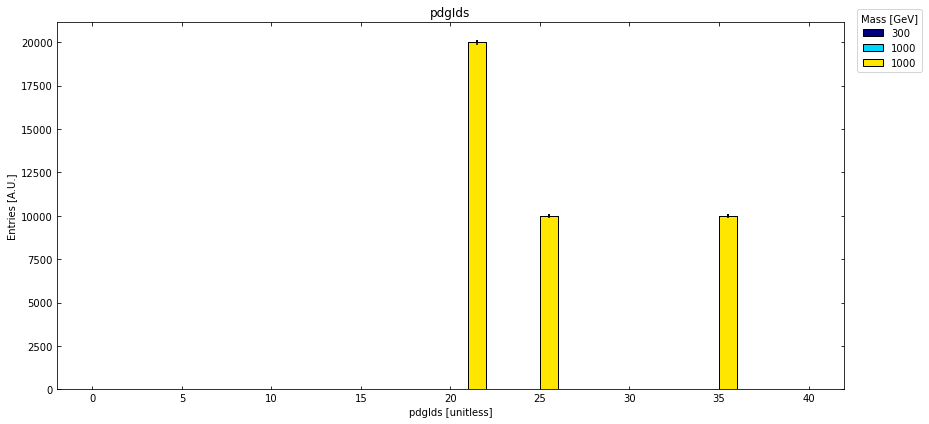

On variable: X_m
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


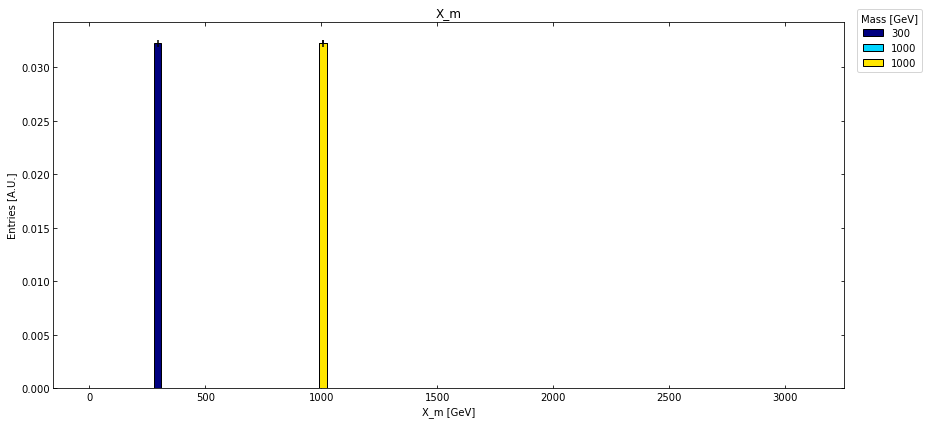

On variable: G_E_sum
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


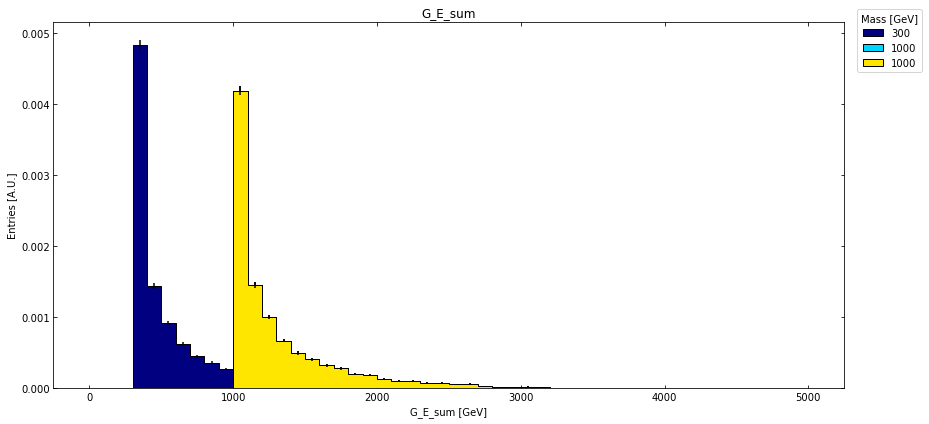

On variable: G_pz_sum
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


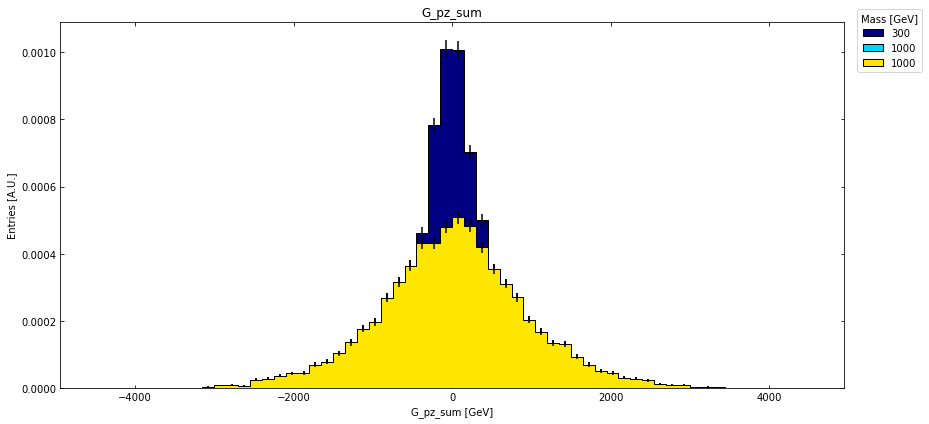

On variable: Lead_H_pt
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


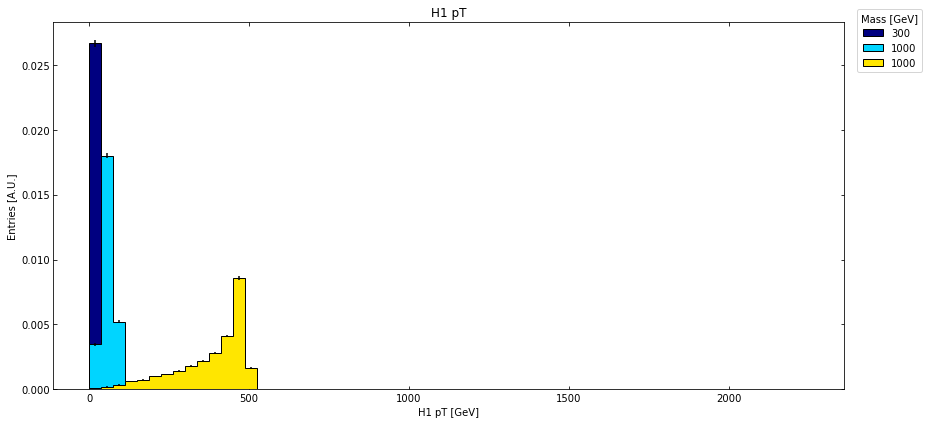

On variable: Sublead_H_pt
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


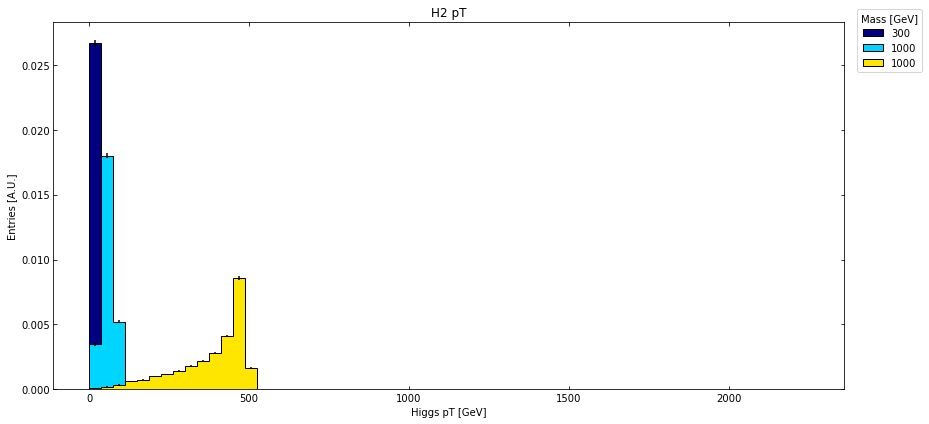

On variable: absH1H2_Deta
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


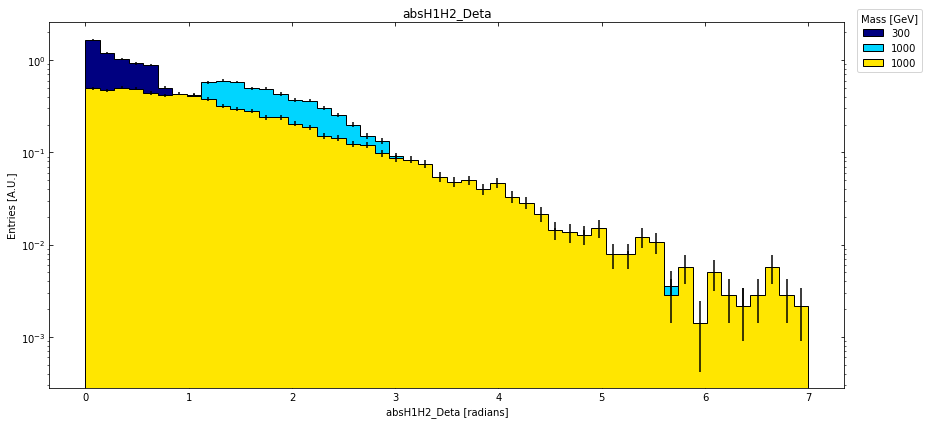

On variable: absH1H2_Dphi
df_name: Dataframes/GF_NMSSM/300_170.p
df_name: Dataframes/GF_NMSSM/1000_850.p
df_name: Dataframes/GF_NMSSM/1000_85.p


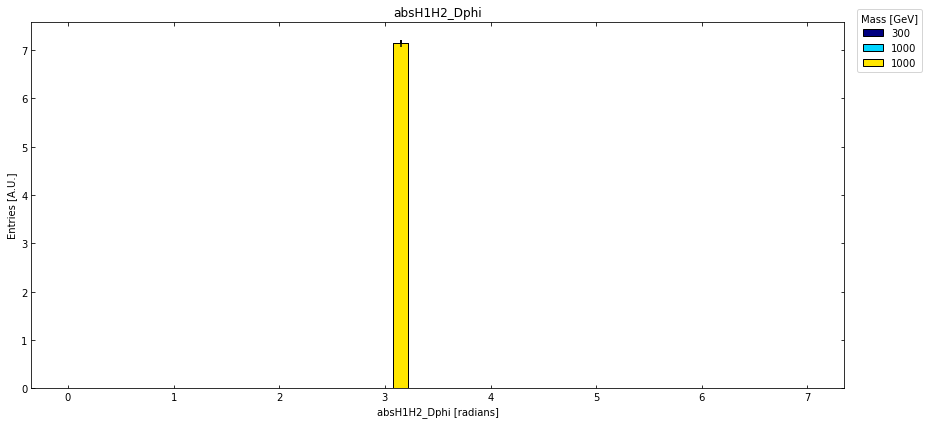

DONE


In [6]:
##-- Plot variables for mass points together 
##-- All distributions together

##-- Parameters 
##################
ol = "/eos/user/v/vinguyen/www/UL_Gridpacks/" ##-- Output location for plots 
gridpack_Type = "GF_NMSSM"
legendOutside = 1 ##-- Place legend outside of plot axes 
lessPoints = 0 ##-- Only plot a few mass points 
##################

##-- Define nbins, xmin, xmax, units for variables 
def GetVarParams(v):
    VarDict = {
        "X_eta" : [30, -7, 7, "radians"],
        "absX_eta" : [30, 0, 7, "radians"],
        "X_phi" : [30, -3.14, 3.14, "radians"],
        "X_px" : [60, -1500 , 1500, "GeV"],
        "X_py" : [60, -1500 , 1500, "GeV"],
        "X_pz" : [60, -4000 , 4000, "GeV"],
        "X_m_over_X_pt" : [50, 0, 25, "unitless"],
        "X_pt_over_X_m" : [60, 0, 2, "unitless"],
        "X_m_over_X_px" : [60, 0, 40, "unitless"],
        "X_m_over_X_py" : [60, 0, 40, "unitless"],
        "X_m_over_X_pz" : [60, 0, 40, "unitless"],
        "HH_px" : [60, -2000 , 2000, "GeV"],
        "HH_py" : [60, -2000 , 2000, "GeV"],
        "HH_pz" : [60, -2000 , 2000, "GeV"],
        "Lead_H_pt" : [60, 0, 2250, "GeV"],
        "Lead_H_px" : [60, -2000 , 2000, "GeV"],
        "Lead_H_py" : [60, -2000 , 2000, "GeV"],
        "Lead_H_pz" : [60, -2000 , 2000, "GeV"],
        "Sublead_H_px" : [60, -2000 , 2000, "GeV"],
        "Sublead_H_py" : [60, -2000 , 2000, "GeV"],
        "Sublead_H_pz" : [60, -2000 , 2000, "GeV"],        
        "Sublead_H_pt" : [60, 0, 2250, "GeV"],
        "Lead_Outgoing_q_pt" : [60, 0, 1300, "GeV"],
        "Sublead_Outgoing_q_pt" : [60, 0, 1300, "GeV"], 
        "Lead_Outgoing_q_eta" : [60, -4, 4, "radians"],
        "Sublead_Outgoing_q_eta" : [60, -4, 4, "radians"],         
        "Lead_Incoming_q_e" : [30, 0, 3000, "GeV"],
        "Sublead_Incoming_q_e" : [30, 0, 3000, "GeV"],
        "incq_E_sum" : [60, 0, 10000, "GeV"],
        "X_pt" : [30, 0, 1500, "GeV"],
        "X_spin" : [4, 0, 4, "unitless"],
        "X_m" : [100, 0, 3100, "GeV"],
        "absX_pz" : [30, 0, 3000, "GeV"],
        "DR_H1H2" : [60, 0, 10, "unitless"],
        "DR_OutqOutq" : [200, 0, 5, "unitless"],
        "OutqOutq_Deta" : [200, 0, 5, "unitless"],
        "OutqOutq_Dphi" : [200, 0, 5, "unitless"],
        "pdgIds" : [40, 0, 40, "unitless"],
        "Lead_H_eta" : [14, -7, 7, "radians"],
        "Lead_H_phi" : [14, -7, 7, "radians"],
        "Sublead_H_eta" : [14, -7, 7, "radians"],
        "Sublead_H_phi" : [14, -7, 7, "radians"],
        "H1H2_Deta" : [50, -5, 5, "radians"] ,
        "H1H2_Dphi" : [50, -5, 5, "radians"],
        "absH1H2_Deta" : [50, 0, 7, "radians"] ,
        "absH1H2_Dphi" : [50, 0, 7, "radians"],        
        "X_e" : [50, 0, 5000, "GeV"],
        "Lead_g_pz" : [60, -3000, 3000, "GeV"],
        "Lead_g_pt" : [10, 0, 100, "GeV"],
        "Sublead_g_pz" : [60, -3000, 3000, "GeV"],
        "Sublead_g_pt" : [10, 0, 100, "GeV"],
        "Lead_g_px" : [60, -3000, 3000, "GeV"],
        "Sublead_g_px" : [60, -3000, 3000, "GeV"],
        "Lead_g_py" : [60, -3000, 3000, "GeV"],
        "Sublead_g_py" : [60, -3000, 3000, "GeV"],
        "G_pz_diff" : [50, 0, 5000, "GeV"],
        "G_pz_sum" : [60, -4500, 4500, "GeV"],
        "G_E_sum" : [50, 0, 5000, "GeV"],
    }
    return VarDict[v]

##-- Define variables and operation for special variables
SpecialVarInfoDict = {
    "G_pz_diff" : ["Lead_g_pz", "Sublead_g_pz", "subtract"],
    "G_pz_sum" : ["Lead_g_pz", "Sublead_g_pz", "add"],
    "G_E_sum" : ["Lead_g_e", "Sublead_g_e", "add"],
    "incq_E_sum" : ["Lead_Incoming_q_e", "Sublead_Incoming_q_e", "add"],
    "X_m_over_X_pt" : ["X_m", "X_pt", "divide"],
    "X_m_over_X_px" : ["X_m", "X_px", "divide"],
    "X_m_over_X_py" : ["X_m", "X_py", "divide"],
    "X_m_over_X_pz" : ["X_m", "X_pz", "divide"],
    "X_pt_over_X_m" : ["X_pt", "X_pz", "divide"],
    "HH_px" : ["Lead_H_px", "Sublead_H_px", "add"],
    "HH_py" : ["Lead_H_py", "Sublead_H_py", "add"],
    "HH_pz" : ["Lead_H_pz", "Sublead_H_pz", "add"],
}

##-- Get dataframe files 
df_names_ = []
prefix = "Dataframes/%s"%(gridpack_Type)
df_names_ = ["%s/%s"%(prefix, file) for file in os.listdir(prefix)]
##-- Order by mass for plotting order purposes
df_names = sorted(df_names_, key = lambda x: (float(x.split('/')[-1].split('.')[0].split('_')[0]), 
                                              -float(x.split('/')[-1].split('.')[0].split('_')[1])))

##-- Define Validation Variables based on gridpack type 
GF_Vars = ["pdgIds", "X_m", "G_E_sum", "Lead_H_pt", "Sublead_H_pt", "absH1H2_Deta", "absH1H2_Dphi"]
# VBF_Vars = ["pdgIds", "X_m", "Lead_H_pt", "Sublead_H_pt", "X_pt", "Lead_Outgoing_q_pt", "Sublead_Outgoing_q_pt", "DR_HH", "HH_Deta", "HH_Dphi", "DR_OutqOutq", "OutqOutq_Deta", "OutqOutq_Dphi", "X_m_over_X_pt"]
# VBF_Vars = ["incq_E_sum"]
# VBF_Vars = ['X_pt', 'X_px', 'X_py', 'X_pz']
# VBF_Vars = ['Lead_H_px', 'Lead_H_py', 'Lead_H_pz', 'Sublead_H_px', 'Sublead_H_py', 'Sublead_H_pz', "HH_px", "HH_py", "HH_pz"]
# VBF_Vars = ["X_px", "X_py", "X_pz"] 
VBF_Vars = ["absX_eta"] 
GF_NMSSM_Vars = ["pdgIds", "X_m", "G_E_sum", "G_pz_sum", "Lead_H_pt", "Sublead_H_pt", "absH1H2_Deta", "absH1H2_Dphi"]
#GF_NMSSM_Vars = ["X_m"]
ValVarsDict = {
    "GF_Spin-0" : GF_Vars, 
    "GF_Spin-2" : GF_Vars,
    "VBF_Spin-0" : VBF_Vars,
    "VBF_Spin-2" : VBF_Vars,
    "GF_NMSSM" : GF_NMSSM_Vars   
}
variables = ValVarsDict[gridpack_Type]

##-- To hold values for avg +/- stdev vs. Mass plots
masses = []
massesY = []
N_Gluons_vals, N_Higgs_vals = [], [] 
N_Events = 10000 ##-- This is assumed based on LHE file production 

##-- Initialize mean and stdev lists to plot 
for var in variables:
    exec("%s_mean = []"%(var))
    exec("%s_stdev = []"%(var))

##-- For each variable, plot all mass point distributions and save mean and stdev values for var vs. mass point plots 
for v in variables:
    print("On variable:",v)
    
    ##-- Get variable dependent parameters 
    nbins, xmin, xmax, unit = GetVarParams(v)
    allBins = np.linspace(xmin, xmax, nbins + 1)
    
    ##-- Setup Colors 
    cm = plt.get_cmap('jet') ##-- Choose nice color scheme: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    NUM_COLORS = len(df_names)
    fig, ax = plt.subplots()
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    colorsDoubled = [] ##-- to add error bars and hist without incrementing color 
    for ic, c in enumerate(colors):
        colorsDoubled.append(c) ##-- The purpose of doubling colors in the cycle is because both a hist and errorbar are being plotted per mass point. Want same color for both 
        colorsDoubled.append(c)
    ax.set_prop_cycle(color = colorsDoubled)
    
    ##-- For each dataframe (one per LHE file)
    for i, df_name in enumerate(df_names):
        print("df_name:",df_name)
        
        ##-- Dataframe info 
        endPath = df_name.split('/')[-1]
        if(lessPoints):
            if(endPath != "250.p" and endPath != "1000.p" and endPath != "3000.p"): continue
#         colors.append(color)
        df = pickle.load( open( df_name, "rb" ) ) ##-- Load dataframe 
        
        plotLabel = df_name.split('/')[-1].split('_')[0]
        plotLabel = plotLabel.replace(".p","")  
        masses.append(plotLabel)
        plotLabelY = df_name.split('/')[-1].split('_')[-1]
        plotLabelY = plotLabelY.replace(".p","")  
        massesY.append(plotLabelY)        
        
        ##-- Create numpy histogram normalized to integral = 1 
        
        ##-- Get defined special variables (a variable that is actually the sum, difference of division of two variables per event)
        specialVars = [key for key in SpecialVarInfoDict]
        
        ##-- Special cases 
        if(v=='pdgIds' or v =='N_Gluons' or v == 'N_Higgs'):
            allVals = []
            for vals in df['pdgIds']:
                for val in vals:
                    allVals.append(val)
            nonNormyvals, binedges = np.histogram(allVals, bins=nbins, range=(xmin,xmax))
            yvals, binedges = np.histogram(allVals, bins=nbins, range=(xmin,xmax),density=False)
            
        ##-- For each of other special variables, just need to define two variables, and operation. 
        elif(v in specialVars):
            v1_Name, v2_Name, operation = SpecialVarInfoDict[v] ##-- Get two variables and operation for special variable
#             exec("v1_Name = df[%s]"%(v1_Name))
#             exec("v2_Name = df[%s]"%(v2_Name))
            v1 = df[v1_Name]
            v2 = df[v2_Name]
            exec("all_df_vals = np.add(v1, v2)")
            nonNormyvals, binedges = np.histogram(all_df_vals, bins = nbins, range = (xmin, xmax))
            yvals, binedges = np.histogram(all_df_vals, bins=nbins, range=(xmin,xmax),density=True)              
            
        ##-- Non-Special cases 
        else:
            if("abs" in v):
                v_no_abs = v[:].replace("abs", "")
                all_df_vals = abs(df[v_no_abs])
            else:
                v_no_abs = v[:].replace("abs", "")
                all_df_vals = df[v_no_abs]
            if("abs" in v):
                nonNormyvals, binedges = np.histogram(all_df_vals, bins = nbins, range = (xmin, xmax))
                yvals, binedges = np.histogram(all_df_vals, bins=nbins, range=(xmin,xmax),density=True)                
            else:
                nonNormyvals, binedges = np.histogram(all_df_vals, bins = nbins, range = (xmin, xmax))
                yvals, binedges = np.histogram(all_df_vals, bins=nbins, range=(xmin,xmax),density=True)                

        ##-- Save mean and stdev of histogram (except for pdgIds variable since it's a list per event)
        if(v != "pdgIds"):
            mean, stdev = np.average(all_df_vals), np.std(all_df_vals)
            exec("%s_mean.append(mean)"%(v))
            exec("%s_stdev.append(stdev)"%(v))
        
        ##-- Get Poissonian bin uncertainties and scale to normalized bin height
        nonNormYerrors = np.sqrt(nonNormyvals)
        relErrors = np.divide(nonNormYerrors,nonNormyvals, out=np.zeros_like(nonNormYerrors),where=nonNormyvals!=0) 
        errors = yvals * relErrors
        bincenters = 0.5*(binedges[1:]+binedges[:-1])
        width = float(binedges[1])-float(binedges[0])
        
        ##-- Save number of gluons and higgs bosons per event 
        ##-- Note that for VBF pdgId == 21 for incoming / outgoing quarks
        if(v=='pdgIds'):
            for ic,center in enumerate(bincenters):
                val = yvals[ic]
                if(val!=0): 
                    pdgId = int(center - width / 2)
#                     print("pdgId:",pdgId,": ",val)
                    if(pdgId == 21):
                        N_Gluons_vals.append(val)
                    elif(pdgId == 25):
                        N_Higgs_vals.append(val)
                        
        ##-- Define x errors as bin width / 2 for visual purposes 
        xerrors = []
        for bin_i in range(0,nbins): xerrors.append(width/2)
        xerrors_a = np.array(xerrors) # xerrors array 
        binedges = np.delete(binedges,0,0)  
        
        if(v == "X_pz"):
#         if(v == "X_pz" and "VBF_Spin-2" in gridpack_Type):
            zorder_nominal = float(float(NUM_COLORS) - float(i))
        else:
            zorder_nominal = i 
        
        ##-- Plot normalized histogram 
        plt.hist(bincenters,
                 weights = yvals,
#                  histtype = 'step',
#                  alpha = 0, 
                 histtype = 'stepfilled',
                 edgecolor = 'black',
#                  edgecolor = 'black',
                 bins = allBins,
                 label=plotLabel,
                 zorder = zorder_nominal
#                  zorder = i
#                  zorder = float(float(NUM_COLORS) - float(i)) ##-- For opposite mass point z-ordering in plot
        )           
        
        ##-- Add poissonian bin uncertainties 
        plt.errorbar(
                    bincenters,
                    yvals,
                    yerr=errors,
                    ecolor = 'black',
                    linestyle = '',
                    fmt = 'none',
                    zorder = zorder_nominal + 0.5 
#                     zorder = float(float(NUM_COLORS) - float(i)) ##-- For opposite mass point z-ordering in plot
#                     zorder = i + 0.5
        )        
        
    ##-- Decorate plot 
    plt.ylabel("Entries [A.U.]")
    if( (v == "Lead_H_pt" or v == "Sublead_H_pt") and "GF_Spin" in gridpack_Type):
        plt.title("Higgs pT")
        xlabel = "%s [%s]"%("Higgs pT",unit)
    elif( (v == "Lead_H_pt") and "NMSSM" in gridpack_Type):
        plt.title("H1 pT")
        xlabel = "%s [%s]"%("H1 pT",unit)
    elif( (v == "Sublead_H_pt") and "NMSSM" in gridpack_Type):
        plt.title("H2 pT")
        xlabel = "%s [%s]"%("Higgs pT",unit)         
    else:
        plt.title(v)
        xlabel = "%s [%s]"%(v,unit)
    plt.xlabel(xlabel)
    plt.tick_params(direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both') 
    if(v == "DR_H1H2" or v == "absH1H2_Deta" or v == "X_m_over_X_pz"): plt.yscale('log')
    if(legendOutside):
        plt.legend(title = "Mass [GeV]", bbox_to_anchor=(1.01, 1.05), loc='upper left')
        fig.set_size_inches(13, 6)
    else:
        leg = plt.legend(title = "Mass [GeV]")
        fig.set_size_inches(10, 10)
    fig.tight_layout()

    ##-- Save plot to output location as png and pdf assuming gridpack_Type directory exists in output location 
    outName1 = "%s/%s/%s.png"%(ol,gridpack_Type,v)
    outName2 = "%s/%s/%s.pdf"%(ol,gridpack_Type,v)
    plt.savefig(outName1)
    plt.savefig(outName2)
    plt.show()
    plt.close()         
            
print("DONE")


Saving: /eos/user/v/vinguyen/www/UL_Gridpacks//GF_NMSSM/Higgs_Per_Event.png
Saving: /eos/user/v/vinguyen/www/UL_Gridpacks//GF_NMSSM/Higgs_Per_Event.pdf


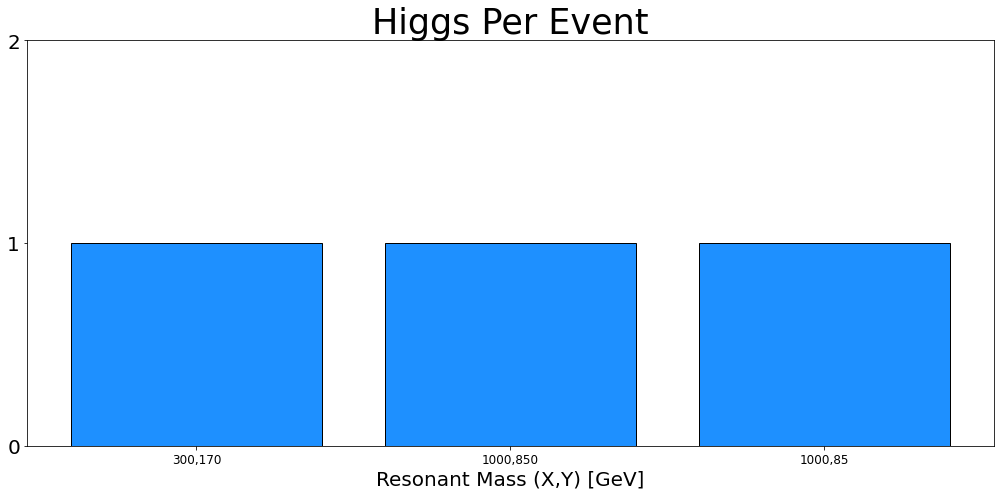

In [167]:
##-- Produce variable average vs. Mass point version of plots

# ##-- Plot number of particles per event 
if("pdgIds" in variables):
#     N_Gluons_vals_perE = [val/N_Events for val in N_Gluons_vals] 
    N_Higgs_vals_perE = [val/N_Events for val in N_Higgs_vals]

#     mass_G_pairs = sorted(list(zip(masses, N_Gluons_vals_perE)), key = lambda x: (float(x[0])))
    mass_H_pairs = sorted(list(zip(masses, N_Higgs_vals_perE, massesY)), key = lambda x: (float(x[0]),-float(x[-1])))
    orderedMasses = [i[0] for i in mass_H_pairs]
    orderedMassesY = [i[2] for i in mass_H_pairs]
#     GluonsPerEvent_values = [i[1] for i in mass_G_pairs]
    HiggsPerEvent_values = [i[1] for i in mass_H_pairs]

    labelcomma = [s + ',' for s in orderedMasses]
    labelXY = [i + j for i, j in zip(labelcomma, orderedMassesY)]
    
    x_pos = [i for i, _ in enumerate(orderedMasses)]
    y_pos = np.arange(len(orderedMasses))

    ##-- Particles Per Event vs. Mass plots 
#     for p in ["Gluons", "Higgs"]:
    for p in ["Higgs"]:
        fig, ax = plt.subplots()
        fig.set_size_inches(14, 7)
        vals = eval("%sPerEvent_values"%(p))
        plt.bar(y_pos, vals, align='center', color = 'dodgerblue', edgecolor = 'black')
        plt.xticks(y_pos, labelXY, fontsize = 12)
        plt.xlabel('Resonant Mass (X,Y) [GeV]', fontsize = 20)
        plt.yticks([0, 1, 2], ["0","1","2"], fontsize = 20)
        plt.title("%s Per Event"%(p), fontsize = 35)
        fig.tight_layout()
        outName1 = "%s/%s/%s.png"%(ol,gridpack_Type,"%s_Per_Event"%(p))
        outName2 = "%s/%s/%s.pdf"%(ol,gridpack_Type,"%s_Per_Event"%(p))
        print("Saving:",outName1)
        print("Saving:",outName2)
        plt.savefig(outName1)
        plt.savefig(outName2)
        plt.show()
        plt.close()

Plotting Bar Graphs:
X_m vs. Mass
G_E_sum vs. Mass
G_pz_sum vs. Mass
Lead_H_pt vs. Mass
Sublead_H_pt vs. Mass
absH1H2_Deta vs. Mass
absH1H2_Dphi vs. Mass
---------------------
Plotting 2d Scatters:
X_m vs. Mass


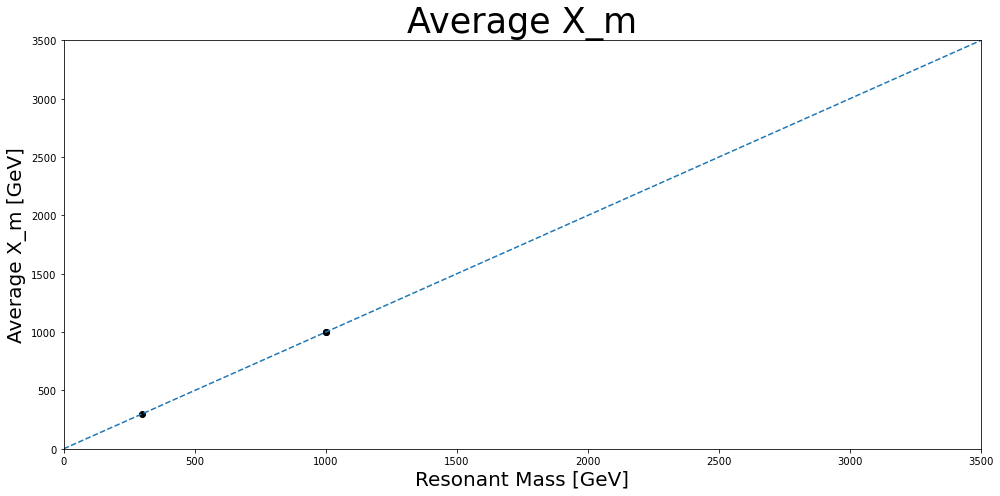

G_E_sum vs. Mass


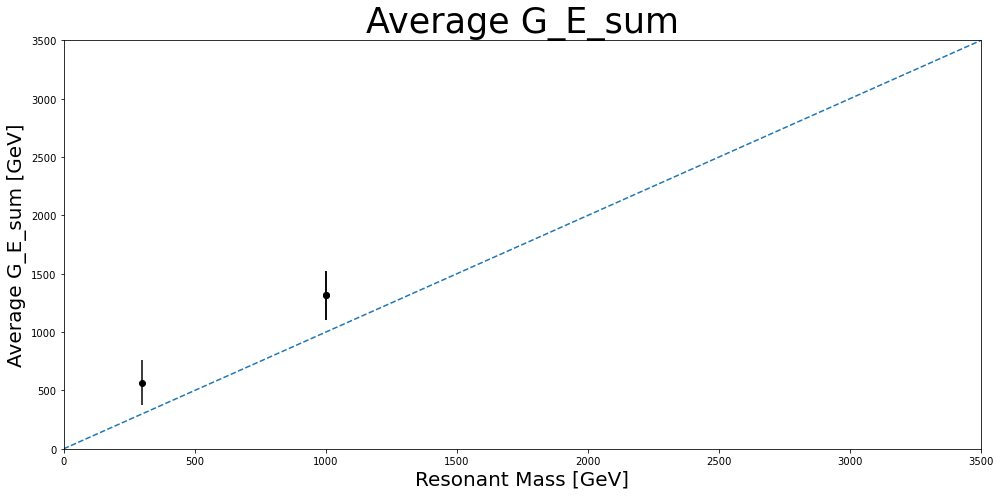

G_pz_sum vs. Mass


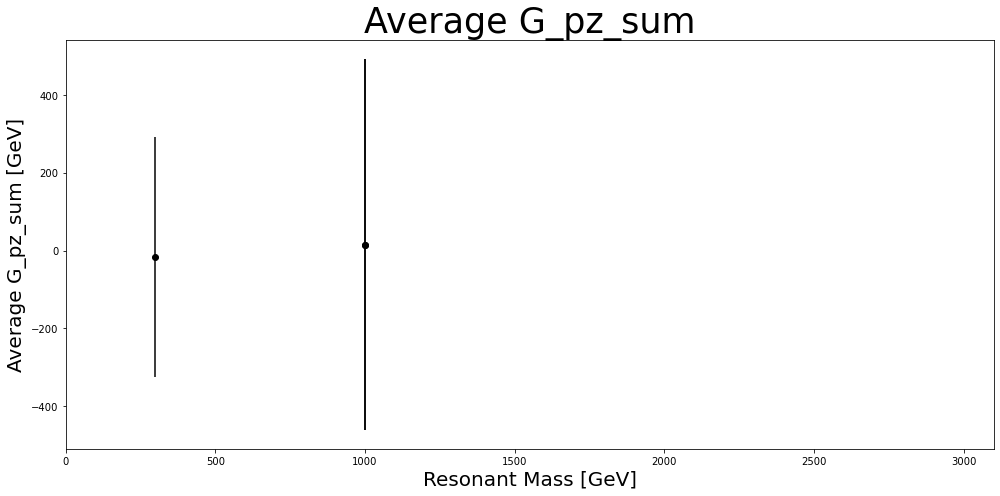

Lead_H_pt vs. Mass


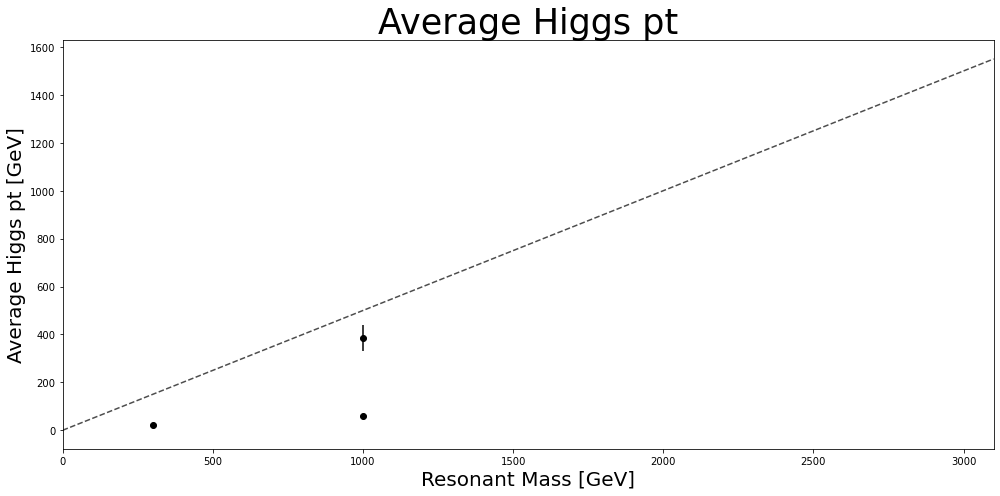

Sublead_H_pt vs. Mass


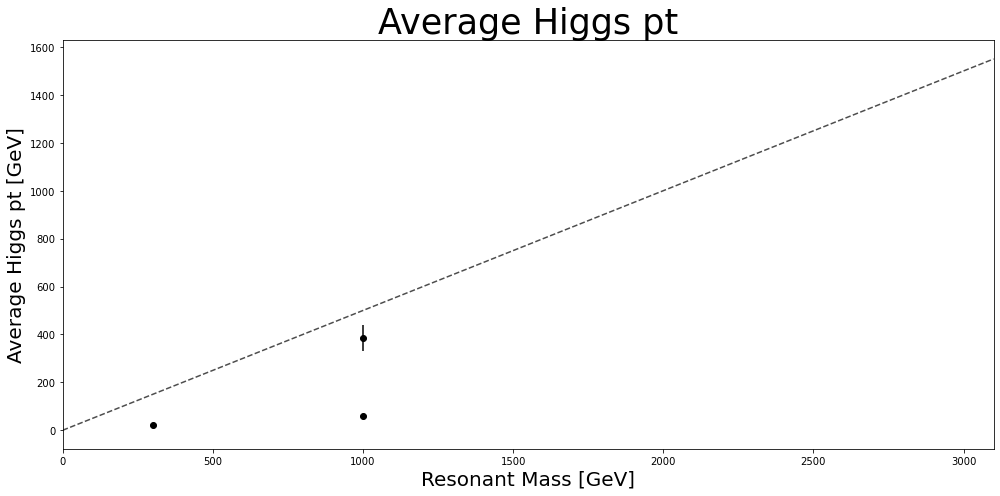

absH1H2_Deta vs. Mass


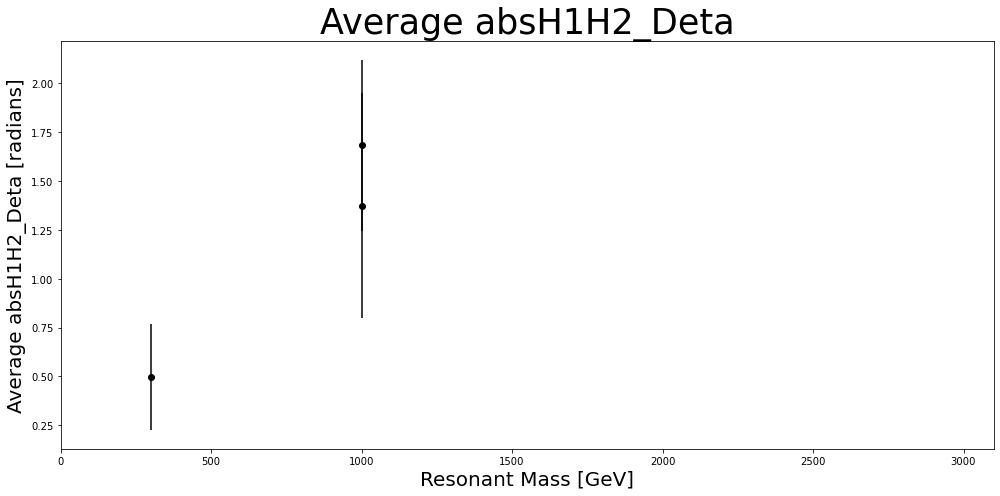

absH1H2_Dphi vs. Mass


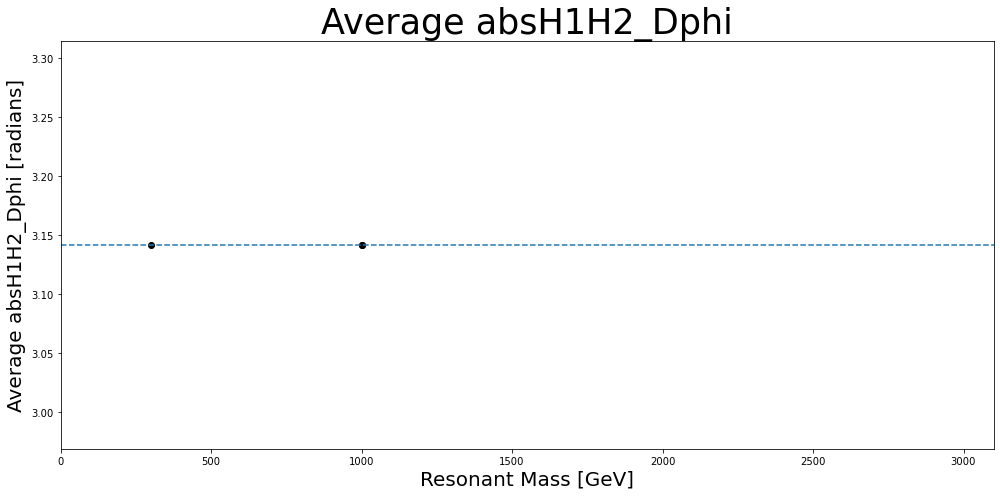

DONE


In [166]:
##-- Plot bar graphs - One bin per mass point. X axis does not scale with variable
print("Plotting Bar Graphs:")
for v in variables:
    if(v == "pdgIds"): continue 
    unit = GetVarParams(v)[3]
    print("%s vs. Mass"%(v))

    ##-- Get variable mean and stdev values per mass point 
    exec("mean_vals = %s_mean"%(v))
    exec("stdev_vals = %s_stdev"%(v))

    ##-- Sort values by increasing resonant mass value 
    exec("massMeanPairs_Sorted = sorted(list(zip(masses, mean_vals)), key = lambda x: (float(x[0])))")
    exec("massStdevPairs_Sorted = sorted(list(zip(masses, stdev_vals)), key = lambda x: (float(x[0])))")
    orderedMasses = [i[0] for i in massMeanPairs_Sorted]
    orderedMeans = [i[1] for i in massMeanPairs_Sorted]
    orderedStdevs = [i[1] for i in massStdevPairs_Sorted] 
    orderedStddevs_oneSide = [i / 2. for i in orderedStdevs] ##-- Divide by 2 to define symmetric uncertainty
    x_pos = [i for i, _ in enumerate(orderedMasses)]
    y_pos = np.arange(len(orderedMasses))   
    
    ##-- Prepare Plot 
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7) ##-- Wide because of the many resonant mass points 
    plt.bar(y_pos, orderedMeans, color = 'dodgerblue', align='center', edgecolor = 'black') 
    plt.errorbar(y_pos, orderedMeans, yerr=orderedStddevs_oneSide, ecolor = 'black', linestyle = '')
    plt.scatter(y_pos, orderedMeans, color = 'black')
    plt.xticks(y_pos, orderedMasses, fontsize = 10)
    plt.xlabel('Resonant Mass [GeV]', fontsize = 20)
    plt.yticks(fontsize = 20)
    if(v == "X_spin"): plt.yticks([-1, 0, 1], ["-1","0","1"], fontsize = 20)
    if((v == "Lead_H_pt" or v == "Sublead_H_pt") and "GF" in gridpack_Type):
        vTitle = "Higgs pt"
    else: 
        vTitle = v
    plt.title("Average %s"%(vTitle), fontsize = 35)
    plt.ylabel("Average %s [%s]"%(vTitle, unit), fontsize = 20)
    fig.tight_layout()
    outName1 = "%s/%s/vmassplots/%s.png"%(ol,gridpack_Type,"BarGraph_%s_vs_mass"%(vTitle))
    outName2 = "%s/%s/vmassplots/%s.pdf"%(ol,gridpack_Type,"BarGraph_%s_vs_mass"%(vTitle))

    plt.savefig(outName1)
    plt.savefig(outName2)
    plt.close()
    
 
print("---------------------")
print("Plotting 2d Scatters:")
##-- 2D graph: Variable vs. mass point, x axis is properly scaled to mass value
for v in variables:
    if(v == "pdgIds"): continue 
    print("%s vs. Mass"%(v))
    unit = GetVarParams(v)[3]    

    ##-- Get variable mean and stdev values per mass point 
    exec("mean_vals = %s_mean"%(v))
    exec("stdev_vals = %s_stdev"%(v))

    ##-- Sort values by increasing resonant mass value 
    exec("massMeanPairs_Sorted = sorted(list(zip(masses, mean_vals)), key = lambda x: (float(x[0])))")
    exec("massStdevPairs_Sorted = sorted(list(zip(masses, stdev_vals)), key = lambda x: (float(x[0])))")
    orderedMasses = [i[0] for i in massMeanPairs_Sorted]
    orderedMeans = [i[1] for i in massMeanPairs_Sorted]
    orderedStdevs = [i[1] for i in massStdevPairs_Sorted] 
    orderedStddevs_oneSide = [i / 2. for i in orderedStdevs] ##-- Divide by 2 to define symmetric uncertainty
    x_pos = [i for i, _ in enumerate(orderedMasses)]
    y_pos = np.arange(len(orderedMasses))   
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)   
    orderedMasses_vals = [float(val) for val in orderedMasses]
    if(v == "X_m" or v == "G_E_sum"): 
        plt.plot([0, 1], [0, 1] , linestyle = "--", transform=ax.transAxes)
        plt.xlim(0, 3500)
        plt.ylim(0, 3500)   
    if("phi" in v):
        plt.plot([0, 1], [0.5, 0.5] , linestyle = "--", transform=ax.transAxes)
#         plt.xlim(0, 3500)
#         plt.ylim(0, 3500)         
    plt.scatter(orderedMasses_vals, orderedMeans, color = 'black')
    plt.errorbar(orderedMasses_vals, orderedMeans, yerr=orderedStddevs_oneSide, ecolor = 'black', linestyle = '')
    if((v == "Lead_H_pt" or v == "Sublead_H_pt") and "GF" in gridpack_Type):
        vTitle = "Higgs pt"
        ax.plot([0, 3100], [0, 1550], ls="--", c=".3")
    else: 
        vTitle = v[:]
    plt.title("Average %s"%(vTitle), fontsize = 35)
    plt.ylabel("Average %s [%s]"%(vTitle, unit), fontsize = 20)
    plt.xlabel('Resonant Mass [GeV]', fontsize = 20)
    if(v != "X_m" and v != "G_E_sum"): 
        plt.xlim(0, 3100)
    fig.tight_layout()
    
    outName1 = "%s/%s/vmassplots/%s.png"%(ol,gridpack_Type,"2dGraph_%s_vs_mass"%(vTitle))
    outName2 = "%s/%s/vmassplots/%s.pdf"%(ol,gridpack_Type,"2dGraph_%s_vs_mass"%(vTitle))

    plt.savefig(outName1)
    plt.savefig(outName2)
    plt.show()
    plt.close()     
    
print("DONE")    
